In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.preprocessing import Imputer
import DesicionTree as dt
import Dataset as ds

In [3]:
def Bagging_RSM(x, y, port):
    features =[]
    while not features:
        for i in range(x.shape[1]):
            checkf = np.random.randint(3)
            if checkf == 1:
                features.append(i)
    newx, newy = [], []
    
    for s in range(x.shape[0]):
        check = np.random.randint(port)
        if check == 1:
            xx = []
            for f in features:
                xx.append(x[s][f])
            newx.append(np.asarray(xx))
            newy.append(y[s])
    return np.asarray(newx), np.asarray(newy), features

In [4]:
def tree_weak_cls(X, tree):
    return dt.predict(tree[0], X[tree[1]])

In [5]:
def make_tree(X, Y, max_depth, min_size, port):
    X, Y, features = Bagging_RSM(X, Y, port)
    return dt.get_tree(X, Y, max_depth, min_size), features

In [6]:
def Q(X, Y, W, tree, features):
    Qsum = 0
    for i in range(X.shape[0]):
        b = dt.predict(tree, X[i, features])
        I = 1 if (Y[i]*b) < 0 else 0
        Qsum += W[i] * I
    return Qsum

In [7]:
def alpha(Q):
    return 0.5 * np.log((1-Q)/Q)

In [61]:
def fit(X, Y, num_weak_clf, T, port, max_depth_range=3, min_size_range=3, alphas = [], bs = [], w = []):
    #1 инициализация весов объектов
    if not len(w):
        w = np.asarray([1/X.shape[0] for i in range(X.shape[0])])
    else:
        alphas = list(alphas)
        bs = list(bs)
    
    #2 Для всех t=1,...,T, пока не выполнен критерий останова.
    while len(alphas) < num_weak_clf:     
        #2.1 Находим классификатор b_t: X->{-1,+1} который минимизирует взвешенную ошибку классификации;
        #b_t = argmin_b Q(b,W^l);
        Qs = []
        trees = []
        for i in range(T):
            tree, features = make_tree(X, Y, 1+np.random.randint(max_depth_range), 1+np.random.randint(min_size_range), port)
            #tree, features = make_tree(X, Y, max_depth_range, min_size_range, port)
            trees.append((tree, features))
            Qs.append(Q(X, Y, w, tree, features))
            
        Qs = np.asarray(Qs)
        argmin = np.argmin(Qs)
        
        if Qs[argmin]> 0.5:
            pass
        else:
            bs.append(trees[argmin])
            #2.2 Пересчитываем кооэффициент взвешенного голосования для алгоритма классификации b_t:

            alpha_t = alpha(Qs[argmin])
            alphas.append(alpha_t)

            #2.3 Пересчет весов объектов: w_i = w_i*exp(-alpha_t*y_i*b_t(x_i)), i = 1,...,l
            for i in range(w.shape[0]):
                b = tree_weak_cls(X[i], trees[argmin])
                w[i] *= np.exp(-alpha_t*Y[i]*b)

            #2.4 Нормировка весов объектов:

            w0 = np.sum(w)
            for ww in w:
                ww/=w0
            
            print('--------------------------')
            print('Was made {num}th weak clfs:'.format(num=len(alphas)))
            dt.print_tree(trees[argmin][0])
            print('With features: {fs}'.format(fs=trees[argmin][1]))
            print('--------------------------\n\n')
    return np.asarray(alphas), np.asarray(bs), w
        

In [9]:
def predict(X, alphas, tree):
    tmp_sum = 0
    for t in range(alphas.shape[0]):
        b = tree_weak_cls(X, tree=tree[t])
        tmp_sum += alphas[t] * b
    return np.sign(tmp_sum)

In [10]:
def accuracy(y_true, y_pred):
    counter = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            counter +=1
    return counter/len(y_true)

In [11]:
def plot_progress(X, Y, alphas, bs):
    progress = []
    for i in range(1, len(alphas)+1):
        predictions = []
        for x in X:
            predictions.append(predict(x, alphas[0:i], bs[0:i]))
        acc = accuracy(Y, predictions)
        print('accurecy({T} weak clfs): {acc}\n'.format(acc = acc,T=i))
        progress.append(acc)
    plt.plot(progress)
    #plt.yticks(np.arange(0, 1.0, 0.1))
    plt.show()

In [62]:
x_train, y_train, x_test, y_test = ds.get_dataset()
alphas, bs, w = [], [], []

Dictionary:
 {'1': {'Self-emp-not-inc': 0, 'Private': 1, 'State-gov': 2, 'Federal-gov': 3, 'Local-gov': 4, '?': nan, 'Self-emp-inc': 5, 'Without-pay': 6, 'Never-worked': 7}, '3': {'Bachelors': 0, 'HS-grad': 1, '11th': 2, 'Masters': 3, '9th': 4, 'Some-college': 5, 'Assoc-acdm': 6, 'Assoc-voc': 7, '7th-8th': 8, 'Doctorate': 9, 'Prof-school': 10, '5th-6th': 11, '10th': 12, '1st-4th': 13, 'Preschool': 14, '12th': 15}, '5': {'Married-civ-spouse': 0, 'Divorced': 1, 'Married-spouse-absent': 2, 'Never-married': 3, 'Separated': 4, 'Married-AF-spouse': 5, 'Widowed': 6}, '6': {'Exec-managerial': 0, 'Handlers-cleaners': 1, 'Prof-specialty': 2, 'Other-service': 3, 'Adm-clerical': 4, 'Sales': 5, 'Craft-repair': 6, 'Transport-moving': 7, 'Farming-fishing': 8, 'Machine-op-inspct': 9, 'Tech-support': 10, '?': nan, 'Protective-serv': 11, 'Armed-Forces': 12, 'Priv-house-serv': 13}, '7': {'Husband': 0, 'Not-in-family': 1, 'Wife': 2, 'Own-child': 3, 'Unmarried': 4, 'Other-relative': 5}, '8': {'White': 0, '

In [70]:
num_wclfs = 45
start_time = time.time()
alphas, bs, w = fit(X=x_train, Y=y_train, num_weak_clf=num_wclfs, T=10, port=100, 
                    max_depth_range=21, min_size_range=110, alphas=alphas, bs=bs, w=w)

--------------------------
Was made 43th weak clfs:
[X1 < 29.000]
 [X1 < 24.000]
  [X1 < 22.000]
   [X1 < 18.000]
    [-1.0]
    [X1 < 18.000]
     [-1.0]
     [-1.0]
   [X1 < 22.000]
    [-1.0]
    [-1.0]
  [X1 < 27.000]
   [X2 < 247025.000]
    [X2 < 161027.000]
     [-1.0]
     [X2 < 164737.000]
      [1.0]
      [X2 < 233499.000]
       [X2 < 193701.000]
        [1.0]
        [-1.0]
       [1.0]
    [X1 < 26.000]
     [X1 < 24.000]
      [-1.0]
      [-1.0]
     [-1.0]
   [X1 < 27.000]
    [-1.0]
    [-1.0]
 [X2 < 158077.000]
  [X1 < 39.000]
   [X1 < 32.000]
    [X3 < 27.000]
     [1.0]
     [-1.0]
    [X2 < 136137.000]
     [X2 < 89491.000]
      [X2 < 35945.000]
       [-1.0]
       [X2 < 45796.000]
        [1.0]
        [-1.0]
      [X3 < 10.000]
       [X1 < 38.000]
        [X1 < 34.000]
         [-1.0]
         [X1 < 34.000]
          [-1.0]
          [-1.0]
        [-1.0]
       [1.0]
     [1.0]
   [X1 < 60.000]
    [X2 < 146391.000]
     [X2 < 137192.000]
      [X1 < 44.000]

--- 78147.05787110329 seconds ---

accurecy(1 weak clfs): 0.9842751842751842

accurecy(2 weak clfs): 0.9842751842751842

accurecy(3 weak clfs): 0.9842751842751842

accurecy(4 weak clfs): 0.9842751842751842

accurecy(5 weak clfs): 0.9842751842751842

accurecy(6 weak clfs): 0.9941031941031941

accurecy(7 weak clfs): 0.9866707616707616

accurecy(8 weak clfs): 0.9941031941031941

accurecy(9 weak clfs): 0.9941031941031941

accurecy(10 weak clfs): 0.9941031941031941

accurecy(11 weak clfs): 0.9887592137592137

accurecy(12 weak clfs): 0.989004914004914

accurecy(13 weak clfs): 0.9887592137592137

accurecy(14 weak clfs): 0.9887592137592137

accurecy(15 weak clfs): 0.991031941031941

accurecy(16 weak clfs): 0.991031941031941

accurecy(17 weak clfs): 0.991031941031941

accurecy(18 weak clfs): 0.990970515970516

accurecy(19 weak clfs): 0.990970515970516

accurecy(20 weak clfs): 0.990970515970516

accurecy(21 weak clfs): 0.9944103194103194

accurecy(22 weak clfs): 0.9944717444717445

accurecy(23 w

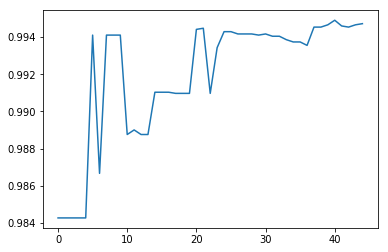

In [72]:
print("--- %s seconds ---\n" % (time.time() - start_time))
plot_progress(x_test, y_test, alphas, bs)

In [73]:
import pickle
with open('meta2.pkl', 'wb') as f:
    pickle.dump((alphas, bs, w), f, pickle.HIGHEST_PROTOCOL)